# Свёрточные сети

Сегодня мы детальнее поговорим про общие подходы при обучении нейросетей, и что происходит внутри них.

<img width='400px' src='https://raw.githubusercontent.com/sslotin/universum-dl/43390d26d5f256dcc68a6ba51998bd626b3f6d33/images/cat.png'>

Если попытаться визуализировать то, что выучивает каждый нейрон в нейросети (например, посмотрев, какие входные пиксели на него сильнее всего влияют), то можно увидеть, что чем глубже находится слой, тем более абстрактные фичи он содержит.

Например, в сетях для распознавания картинок первые слои учатся обнаруживать геометрические примитивы: линии, границы, углы. Следующий слой может распознавать простые геометрические фигуры. Следующий распознаёт наличие целых объектов и т. д.

**Weight sharing**. [Эксперименты с дропаутом](https://arxiv.org/abs/1701.05369) показывают, что в линейном слое примерно 99% весов на самом деле можно выкинуть. Логично, что в оптимальной архитектуре не должно быть бесполезных весов — лишние параметры всегда ведут к переобучению. В случае с картинками решение в том, чтобы использовать информацию о расположении пикселей относительно друг друга.

## Свёртки и пуллинги

**Как хранятся картинки**. Когда говорят «изображение», представляйте не прямоугольник, а параллелепипед, высотой которого будет размер каналов. Например, обычные цветные RGB картинки имеют 3 канала: на красный (R), зелёный (G) и синий (B).

0. Введем такую функцию, как **ядро** (англ. **kernel**) — она считает скалярное произведение вектора-входа со своим вектором-параметром.
1. Разобьем исходный паралеллелепипед на сколько-то параллелепипедов одинакового размера вдоль размерности, соответствующей каналам. Они могут пересекаться.
2. Каждый из них «разгладим» в вектор.
3. К кажому такому вектору и применим по очереди каждый кернел (их обычно берут много разных).
4. Положим то, что получилось, в новый параллелепипед.
5. Посчитаем для кажой ячейки какую-нибудь нелинейность. Обычно это ReLU из-за вычислительных причин.

<img width='350px' src='https://raw.githubusercontent.com/sslotin/universum-dl/43390d26d5f256dcc68a6ba51998bd626b3f6d33/images/conv1.png'>

Эта операция называется **свёрткой**. Помимо кернела, в ней есть другие параметры — паддинг (отступ по краям), страйды (шаги по x и y). Также свёртка может быть в 2d и 3d. Посмотрите этот репозиторий, чтобы получше разобраться со свёрточной арифметикой: https://github.com/vdumoulin/conv_arithmetic

![](http://deeplearning.net/software/theano/_images/numerical_padding_strides.gif)

**Пулингом** называют операцию, при которой входной тензор так же разбивается на квадраты (не паралепипеды — операция независима по каждому каналу) и на каждом квадрате считается какая-нибудь редукция (чаще всего максимум или среднее по всем значениям в квадрате), после чего полученные значения записываются на следующий слой в том же порядке.

<img width='400px' src='http://cs231n.github.io/assets/cnn/maxpool.jpeg'>

В свёртках переиспользуется очень много параметров: кернел для каждого фильтра (выходного канала) использует один и тот же вектор-параметр для скалярного умножения. Из-за этого каждый фильтр как правило выучивает какую-то конкретную фичу, вроде наличия какого-либо объекта на своём регионе. Пулинг используют затем для понижения размерности: каждый нейрон после свертки выражает степень уверенности, что на регионе присутствует какой-то объект, и поэтому логично в качестве вероятности наличия объекта на регионе из под-регионов использовать максимум или среднее.

Чаще всего используют свёртки 3x3 со страйдом 2x2 (то есть квадраты перекрываются по 3 крайним пикселям) с пулингом размера 2x2 (не перекрываются).

## Аугментация данных

Аугментацией называется процесс получения новых синтетических данных из имеющихся, чтобы подать в обучение. Это часто (особенно в компьютерном зрении) позволяет улучшить качество модели, не используя дополнительных данных.

Формально, в случае с классификацией, аугментация — это любое преобразование, которое корректно изменяет данные, не меняя их класс.

В случае с картинками, можно попробовать добавить следующие преобразования, которые с какой-то вероятностью будут использоваться во время обучения:

* Поворот на малый угол.
* Добавление шума.
* Обрезание границ и последующее растяжение до исходного размера.
* Горизонтальное отражение (но в нашем случае оно вредно).
* Смещение на небольшое расстояние.

Понятно, что лейбл эти преобразования изменить не должны.

<img src='https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/a5da2c3b4174449d13dd746b7d00897c6bc1f334/5-Figure2-1.png' width='500px'>

## Взрывающийся градиент

В сетях происходит очень много чего стохастического: батч формируется случайно, аугментация, рандомизированные слои вроде дропаута, вычислительные ошибки. Это всё может привести к тому, что сеть на какой-то итерации будет очень уверенна в неправильном предсказании и некоторые её параметры получат очень большой градиент. Это может привести к тому, что эти параметры «улетят» куда-то настолько далеко, и после этого сеть будет всегда предсказывать класс, который на этой итерации был правильным. 

Простое решение: просто обрезать градиент в случае, если градиент больше какого-то фиксированного значения. Для этого есть функция `torch.nn.utils.clip_grad_norm_`, которая принимает параметры модели и параметр `threshold`. Она считает норму (длину вектора) градиента и, если она больше `threshold`, нормирует градиенты так, чтобы она была равна `threshold`. Эта функция также возвращает само значение нормы, что может быть очень полезно при анализе обучения (например, если она становится маленькой, то, значит, сеть сходится к какому-то плато).

## Инициализация параметров

Сначала приведем пример плохой инициализации. Пусть мы задали все значения изначально нулями. В таком случае наша модель становится эквивалентна линейной модели — производная по функции потерь одинакова для каждого $w_i$, таким образом, все веса имеют одинаковые значения и в последующей итерации, что делает нейроны в сети симметричными.

Подход получше — инициализировать каждый вес случайно. Но тут нужно быть осторожным — если задать их слишком большими, то сеть может быть изначально очень уверенна в своих предсказаниях, и подвинуть параметры оттуда будет очень трудно.

Решение следующее. С точки зрения слоя, ему на вход подается сэмпл из какого-то распределения, и он под это распределение подстраивается. В нейросетях размеры слоев достаточно большие, чтобы в них работали законы статистики, все разработчики фреймворках условились инициализировать веса всех слоев в предположении, что на вход подаются данные из какого-то распределения со средним 0 и дисперсией 1, и на выходе должно получиться какое-то распределение со средним тоже 0 и дисперсией 1. Чаще всего изначальные веса берут либо из нормального, либо из равномерного распределения, «обрезанного» так, чтобы дисперсия каждого выходного значения получилась единичной.

Аналогично нужно поступать со входными векторными данными: нормализовывать. Это будет важно при работе с изображениями: не надо подавать на вход вектора с элементами от 0 до 255. Самое простое рабочее решение — нормализовать вход, поделив его на 255.

## Минутка физики

Потребляемая энергия в сети с переменным током в единицу времени считается по формуле

$$W = CV^2f$$

где $C$ означает емкость сети, $V$ означает напряжение, а $f$ — частоту. В случае с процессорами, это именно та частота, с которой выполняются элементарные операции, например сложение.

<img width='350px' src='https://i.ibb.co/yhsGRJK/Screenshot-from-2019-02-08-14-52-07.png'>

Однако, если мы сделаем сеть из двух параллельно подключенных процессоров, работающих на половинной частоте, мы можем получить сеть, потребляющую ~40% изначальной энергии, делающую то же количество полезной работы — то же суммарное количество процессорных тактов:

<img width='450px' src='https://i.ibb.co/WgLCxxL/Screenshot-from-2019-02-08-14-52-18.png'>

Поэтому для хорошо распараллеливаемых операций используют другой тип вычислительных устройств, в которых не 4-8 быстрых (3-4 GHz) процессоров, а несколько тысяч медленных (~1GHz).

## Device-agnostic код

К любой модели или тензору в PyTorch можно применить `.cuda()` и `.cpu()`, чтобы перевести тензор на память GPU или в оперативную память соответственно. Но если мы будем писать такой код, нам будет довольно проблематично портировать его на другие машины, где, например, нет GPU (например, если вы хотите скачать тетрадку с colab к себе и запустить).

Многие фреймворки позволяют абстрагироваться от устройства конкретных вычислительных устройств. В PyTorch для этого есть объект `torch.device`, который позволяет явно задавать, на каком устройстве хранить тензор или модель.

# Колоризация изображений

Начнём практическую часть. Обучим autoencoder-like сеть, которая учится восстанавливать изображение по его черно-белой версии. В качестве лосса будем так же использовать какую-нибудь меру расстояния между изображениями (например, l1 или l2).

Тот пайплайн, что у нас получится, с минимальными изменениями можно будет также использовать и для других подобных задач, связанных с восстановлением изображений после каких-либо необратимых преобразований, например после подмешивании шума (denoising autoencoder) или понижения размера (DeepHD).

![](https://camo.githubusercontent.com/c5f95c94d70a3e52561c1d0591e84a5e3b86eb74/687474703a2f2f726963687a68616e672e6769746875622e696f2f636f6c6f72697a6174696f6e2f7265736f75726365732f696d616765732f6e65745f6469616772616d2e6a7067)

In [ ]:
!nvidia-smi

Fri Mar  5 19:58:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional

import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install colorama
from colorama import Fore, Back, Style
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

Для начала скачаем данные. Годятся вообще любые изображения, не обязательно из какого-то изветсного датасета. Этой командой можно скачать и распакавать фотографии с одной школы по программированию, проходившей этим летом.

In [ ]:
!wget http://sereja.me/f/universum_compressed.tar
!tar xf universum_compressed.tar

--2021-03-05 19:59:01--  http://sereja.me/f/universum_compressed.tar
Resolving sereja.me (sereja.me)... 213.159.215.132
Connecting to sereja.me (sereja.me)|213.159.215.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72028160 (69M) [application/x-tar]
Saving to: ‘universum_compressed.tar.19’

universum_compresse 100%[===================>]  68.69M  5.24MB/s    in 13s     

2021-03-05 19:59:15 (5.15 MB/s) - ‘universum_compressed.tar.19’ saved [72028160/72028160]



Есть два подхода к работе с данными:

1. Сначала преобразовать все имеющиеся данные к виду, который принимает нейросеть (сразу к тензорам одинакового размера).
2. Хранить сырые данные и преобразование препроцессинга (функцию) и собирать батчи на лету.

Если это не что-то совсем простое, то второй вариант предпочтительнее, так как он не требует дополнительной памяти (датасеты могут быть большими), времени на векторизацию датасета, а так же сбор батча «на лету» позволяет там же делать аугментацию.

Для этого в PyTorch есть две абстракции: `Dataset` и `DataLoader`.

`Dataset` — абстрактный класс, от которого нужно отнаследовать класс датасета, который мы напишем. В нём должны быть определён конструктор (в нём обычно загружаются в память сырые данные, которые лежат где-то на диске, а также сохраняется какая-нибудь другая информация), метод `__len__` (должен вернуть размер датасета) и `__getitem__`, который должен по номеру сэмпла вернуть его в виде тензора (возможно, произведя какой-нибудь препроцессинг).

In [ ]:
import os
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass
                #print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

Чтобы подавать картинки на вход нейросети, нужно их перевести в тензоры, причём одинакового размера.

In [ ]:
transform_all = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.RandomPerspective(0.07, p=0.5),
    transforms.ToTensor(),
])

def to_grayscale(x):
    return (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)

Здесь `transform_all` и `to_grayscale` являются функциями (формально, первый является функтором), которые мы передадим дальше в `DataLoader`, который оборачивает датасет и позволяет итерироваться по нему по батчам, а также реализует разные полезные функции вроде перемешивания данных после каждой эпохи.

In [ ]:
dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

100%|██████████| 1254/1254 [00:01<00:00, 895.47it/s] 


**Skip-connection**. Иногда бывает полезно присоединить к выходу какого-то слоя его вход, чтобы следующий получил такую же, неизменённую копию. Здесь мы поступим именно так: подадим исходное черно-белое изображение в какую-то одну часть сети, которая сконцентрируется на определении цвета, а затем припишем последним слоем её выход и отправим дальше другому модулю, который уже раскрасит это исходное изображение. От простоты `nn.Sequential`, правда, уже придётся отказаться, и нужно написать свой класс.

In [ ]:
def Block(channels_in, channels_out):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
        nn.MaxPool2d((2, 2), stride=(2, 2)),
        nn.Dropout(p=0.2),
        nn.BatchNorm2d(channels_out),
        nn.SiLU(),
    )

def Upsample_block(channels_in, channels_out):
    return nn.Sequential(
        nn.Upsample(scale_factor=2),         
        nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
        nn.Dropout(p=0.1),
        nn.BatchNorm2d(channels_out),
        nn.SiLU(),
    )

In [ ]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential(
            Block(1, 32),
            Block(32, 64),
            Block(64, 128),
            Block(128, 384),
            #---
            Upsample_block(384, 256),
            Upsample_block(256, 128),
            Upsample_block(128, 64),
            Upsample_block(64, 64),
        )
         
        self.postconcat = nn.Sequential(         # эту сетку можно особо не увеличивать - она не должна быть очень умной
            nn.Conv2d(65, 32, (3, 3), padding=1),# подумайте, откуда у автора тут 65
            nn.SiLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        #print(h.shape, x.shape)
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

Глубокие сети очень часто состоят из повторяющихся блоков, отличающихся только размерностью (в данном случае — количеством фильтров). Чтобы сократить количество кода и уменьшить вероятность багов, блоки можно обернуть в одну функцию, возвращающую мини-модель из нескольких слоев.

Концептуальный пример:

Дальше как обычно:

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [ ]:
num_epochs = 650
lr = 1e-3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model = Colorizer().to(device)
model.apply(weights_init)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.SmoothL1Loss()  # тут можно поиграться с лоссами
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

In [ ]:
def show_img(sample):
    img = sample[1]
    img = img / 2 + 0.5
    npimg = img.numpy()
    npimg = np.clip(npimg, 0., 1.)
    npimg_color = np.transpose(npimg, (1, 2, 0))
    X = sample[0]
    _, H, W = X.shape
    img = np.zeros((H, W, 3))
    img[:,:,1] = img[:,:,2] = img[:,:,0] = X
    f = plt.figure(figsize=(20, 20))
    f.add_subplot(1,3, 1)
    plt.imshow(img)
    f.add_subplot(1,3, 2)
    plt.imshow(npimg_color)
    if len(sample) > 2:
        rest = sample[2]
        npimg = rest.numpy()
        npimg = np.clip(npimg, 0., 1.)
        npimg_color = np.transpose(npimg, (1, 2, 0))
        f.add_subplot(1,3, 3)
        plt.imshow(npimg_color)
    plt.show(block=True)

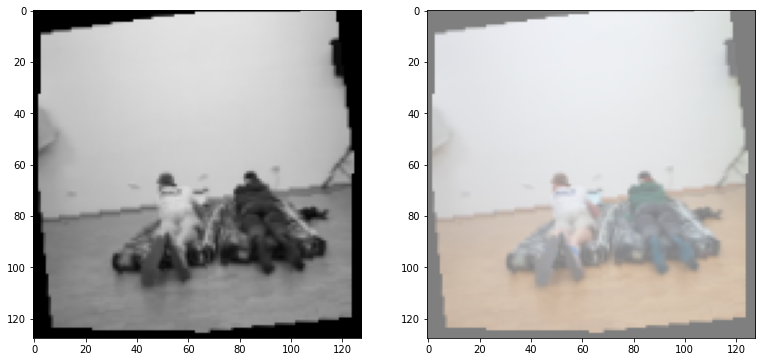

In [ ]:
show_img(dataset[0])

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
        self.history = []

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        self.history.append(self.avg)

    def plot(self):
        plt.plot(self.history)
        plt.show()
        
    def truncate(self, n):
        self.history = self.history[:-(n%len(self.history))]

In [ ]:
predicting = dataset[0][0].reshape((1, 1, 128, 128)).to(device)

In [ ]:
losses = AverageMeter()
prev = float('inf')
for epoch in range(num_epochs):
    for x, y in (loader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        rest = model(x)
        loss = criterion(rest, y)
        loss.backward()
        optimizer.step()
        losses.update(loss.cpu().item(), x.size(0))
        xx = x[0]
        yy = y[0]
        rrest = rest[0]
        del rest
        del x
        del y
        torch.cuda.empty_cache()
    scheduler.step()
    model.eval()
    tm = model(predicting)[0].detach().cpu()
    model.train()
    npimg = tm.numpy()
    npomg = np.clip(npimg, 0., 1.)
    npimg_color = np.transpose(npimg, (1, 2, 0))
    print(f"{b_}Epoch {epoch} \t LR: {scheduler.get_last_lr()}{sr_}")
    if epoch % 5 == 0:
        losses.plot()
        print(f"{g_}Epoch {epoch} of {num_epochs} \n Loss: {losses.avg} \n Iters all: {losses.count}")
        show_img((xx.detach().cpu(), yy.detach().cpu(), rrest.detach().cpu()))

Output hidden; open in https://colab.research.google.com to view.

## *Тизер: adversarial loss

У нашего подхода к колоризации есть одна весьма существенная проблема: непонятно, как определять функцию потерь. Выясняется, что l1 или l2 в некоторых случаях даже являются принципиально неправильным выбором. Представьте, что у нас есть датасет фотографий с летнего лагеря, в котором все люди ходят в футболках двух разных цветов — например, красного и синего — интенсивность которых одинакова и неотличима на черно-белых версиях. Тогда наш лосс заставит сеть выбирать что-то «по середине» (в случае с l2 это будет среднее, а с l1 медиана), и, скорее всего, она сгенерирует что-то серое, в то время как она должна с какой-то вероятностью сгенерировать явно красную или явно синюю футболку.

Решение в следующем: выход (колоризованное изображение) кормить в другую сеть, которая учится определять «правдоподобность» раскраски. Помимо восстановления изображения с точки зрения какой-то меры близости, сети-генератору (колоризатору) нужно ещё и обмануть сеть-дискриминатор, а сети-дискриминатору нужно наоборот, учиться отличать настоящую колоризацию от нашей.

Подобные схемы с двумя состязяющимися сетями называют GAN-ам (Generative Adversarial Networks), о которых мы поговорим через занятие.